<a href="https://colab.research.google.com/github/GrigoryBartosh/dul_2021/blob/main/Practice/pr11/Practice11_contrastive.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import os
from copy import deepcopy
import matplotlib.pyplot as plt
import matplotlib
from tqdm.notebook import tqdm


import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.utils.data as data
import torch.optim as opt




import torchvision
from torchvision.datasets import STL10, CIFAR10
from torchvision import transforms

from sklearn.metrics import accuracy_score
from scipy.stats import mannwhitneyu
import numpy as np

In [2]:
device = torch.device("cuda:0") if torch.cuda.is_available() else torch.device("cpu")

# SimCLR


<center width="100%"><img src="https://github.com/phlippe/uvadlc_notebooks/blob/master/docs/tutorial_notebooks/tutorial17/simclr_contrastive_learning.png?raw=1" width="500px"></center>

In [3]:
class ContrastiveTransformations(object):
    def __init__(self, base_transforms, n_views=2):
        self.base_transforms = base_transforms
        self.n_views = n_views
        
    def __call__(self, x):
        return [self.base_transforms(x) for i in range(self.n_views)]

In [ ]:
contrast_transforms = transforms.Compose([transforms.RandomHorizontalFlip(),
                                          transforms.RandomResizedCrop(size=32),
                                          transforms.ToTensor(),
                                          transforms.Normalize((0.5,), (0.5,))
                                         ])

In [ ]:
train_data = CIFAR10(root='./', train=True, download=True, 
                       transform=ContrastiveTransformations(contrast_transforms, n_views=2))
test_data = CIFAR10(root='./', train=False, download=True, 
                        transform=transforms.Compose([transforms.ToTensor(), transforms.Normalize((0.5,), (0.5,))]))

  0%|          | 0/170498071 [00:00<?, ?it/s]

Extracting ./cifar-10-python.tar.gz to ./
Files already downloaded and verified


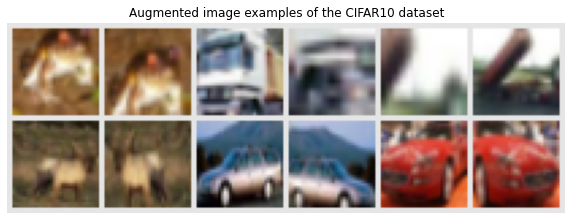

In [ ]:
NUM_IMAGES = 6
imgs = torch.stack([img for idx in range(NUM_IMAGES) for img in train_data[idx][0]], dim=0)
img_grid = torchvision.utils.make_grid(imgs, nrow=6, normalize=True, pad_value=0.9)
img_grid = img_grid.permute(1, 2, 0)

plt.figure(figsize=(10,5))
plt.title('Augmented image examples of the CIFAR10 dataset')
plt.imshow(img_grid)
plt.axis('off')
plt.show()
plt.close()


$$
\ell_{i,j}=-\log \frac{\exp(\text{sim}(z_i,z_j)/\tau)}{\sum_{k=1}^{2N}\mathbb{1}_{[k\neq i]}\exp(\text{sim}(z_i,z_k)/\tau)}=-\text{sim}(z_i,z_j)/\tau+\log\left[\sum_{k=1}^{2N}\mathbb{1}_{[k\neq i]}\exp(\text{sim}(z_i,z_k)/\tau)\right]
$$


$$
\text{sim}(z_i,z_j) = \frac{z_i^\top \cdot z_j}{||z_i||\cdot||z_j||}
$$

In [4]:
class Net(nn.Module):
    def __init__(self, out_dim=128, hid_dim_full=128):
        super(Net, self).__init__()

        self.conv1 = nn.Conv2d(3, 16, 5, padding=2)
        self.conv2 = nn.Conv2d(16, 16, 3, padding=1, stride=2)
        self.conv3 = nn.Conv2d(16, 32, 5, padding=2)
        self.conv4 = nn.Conv2d(32, 32, 3, padding=1, stride=2)
        self.conv5 = nn.Conv2d(32, 32, 1)
        self.conv6 = nn.Conv2d(32, 4, 1)
        self.bn1 = nn.BatchNorm2d(16)
        self.bn2 = nn.BatchNorm2d(16)
        self.bn3 = nn.BatchNorm2d(32)
        self.bn4 = nn.BatchNorm2d(32)
        self.bn5 = nn.BatchNorm2d(32)
        self.bn6 = nn.BatchNorm2d(4)

        self.conv_to_fc = 8 * 8 * 4
        self.fc1 = nn.Linear(self.conv_to_fc, hid_dim_full)
        self.fc2 = nn.Linear(hid_dim_full, int(hid_dim_full // 2))

        self.features = nn.Linear(int(hid_dim_full // 2), out_dim)


    def forward(self, x):
    
        x = F.relu(self.bn1(self.conv1(x)))
        x = F.relu(self.bn2(self.conv2(x)))
        x = F.relu(self.bn3(self.conv3(x)))
        x = F.relu(self.bn4(self.conv4(x)))
        x = F.relu(self.bn5(self.conv5(x)))
        x = F.relu(self.bn6(self.conv6(x)))

        x = x.view(-1, self.conv_to_fc)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))

        features = self.features(x)

        return features

In [ ]:
Net(128, 128)

Net(
  (conv1): Conv2d(3, 16, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
  (conv2): Conv2d(16, 16, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
  (conv3): Conv2d(16, 32, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
  (conv4): Conv2d(32, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
  (conv5): Conv2d(32, 32, kernel_size=(1, 1), stride=(1, 1))
  (conv6): Conv2d(32, 4, kernel_size=(1, 1), stride=(1, 1))
  (bn1): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (bn2): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (bn3): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (bn4): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (bn5): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (bn6): BatchNorm2d(4, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (fc1): Linear(in_features=256, o

In [5]:
class SimCLR(nn.Module):
    def __init__(self, hidden_dim=128, temperature=0.07):
        super().__init__()
        self.hd = hidden_dim
        self.temp = temperature
        self.convnet = Net(128, 128)
        
    def loss(self, batch):
        imgs, _ = batch
        imgs = torch.cat(imgs, dim=0).to(device)
        
        feats = self.convnet(imgs)

        cos_sim = F.cosine_similarity(feats[:,None,:], feats[None,:,:], dim=-1)
        self_mask = torch.eye(cos_sim.shape[0], dtype=torch.bool, device=cos_sim.device)
        cos_sim.masked_fill_(self_mask, -9e15)
        pos_mask = self_mask.roll(shifts=cos_sim.shape[0]//2, dims=0)
        cos_sim = cos_sim / self.temp
        nll = -cos_sim[pos_mask] + torch.logsumexp(cos_sim, dim=-1)
        nll = nll.mean()
        



        comb_sim = torch.cat([cos_sim[pos_mask][:,None], 
                              cos_sim.masked_fill(pos_mask, -9e15)], 
                             dim=-1)
        sim_argsort = comb_sim.argsort(dim=-1, descending=True).argmin(dim=-1)

        acc5 = (sim_argsort < 5).float().mean()
        
        return nll, acc5

In [ ]:
def fit(model, lr=5e-4, num_epochs=20):
    num_epochs = 20
    lr = 5e-4
    optim = opt.AdamW(model.parameters(), lr=lr, weight_decay=1e-4)
    lr_scheduler = opt.lr_scheduler.CosineAnnealingLR(optim, T_max=num_epochs, eta_min=lr/50)

    trainloader = data.DataLoader(train_data, batch_size=256, shuffle=True)


    losses = []
    accs = []
    for epoch in tqdm(range(num_epochs)):
        for batch in trainloader:
            loss, acc = model.loss(batch)
            optim.zero_grad()
            loss.backward()
            optim.step()

            losses.append(loss.item())
            accs.append(acc.item())
        print(f"[{epoch:2}/{num_epochs}]:loss={np.mean(losses[-len(trainloader):]):.4f} acc={np.mean(accs[-len(trainloader):]):.4f}")
        lr_scheduler.step()

In [ ]:
model1 = SimCLR().to(device)

In [ ]:
fit(model1)

  0%|          | 0/20 [00:00<?, ?it/s]

[ 0/20]:loss=3.4838 acc=0.5580
[ 1/20]:loss=2.4394 acc=0.7182
[ 2/20]:loss=2.0957 acc=0.7663
[ 3/20]:loss=1.9369 acc=0.7868
[ 4/20]:loss=1.8173 acc=0.8036
[ 5/20]:loss=1.7413 acc=0.8133
[ 6/20]:loss=1.6786 acc=0.8212
[ 7/20]:loss=1.6305 acc=0.8275
[ 8/20]:loss=1.5645 acc=0.8368
[ 9/20]:loss=1.5064 acc=0.8447
[10/20]:loss=1.4780 acc=0.8486
[11/20]:loss=1.4601 acc=0.8511
[12/20]:loss=1.4296 acc=0.8538
[13/20]:loss=1.4043 acc=0.8573
[14/20]:loss=1.3723 acc=0.8624
[15/20]:loss=1.3441 acc=0.8647
[16/20]:loss=1.3522 acc=0.8637
[17/20]:loss=1.3556 acc=0.8627
[18/20]:loss=1.3522 acc=0.8634
[19/20]:loss=1.3263 acc=0.8668


In [6]:
class Classifier(nn.Module):
    def __init__(self):
        super().__init__()
        self.model = nn.Sequential(nn.Linear(128, 256),
                                   nn.ReLU(), 
                                   nn.Linear(256, 128), 
                                   nn.ReLU(),
                                   nn.Linear(128, 64), 
                                   nn.ReLU(),
                                   nn.Linear(64, 10))
    
    def forward(self, x):
        return self.model(x)
    
    def decision_function_loader(self, dataloader):
        """
        :return: calculates decision function on batched data
        """
        y_pred = []
        y_true = []

        for (x, y) in dataloader:
            res = self(x.to(device).float())
            res = torch.argmax(res, dim=-1)
            y_pred.append(res.squeeze().detach().cpu().numpy())
            y_true.append(y.squeeze().detach().cpu().numpy())

        return np.hstack(y_pred), np.hstack(y_true)


    def fit(self, traindata, lr=1e-3, bs=100, num_epochs=100):
        optim = opt.Adam(self.parameters(), lr=lr)
        scheduler = opt.lr_scheduler.ExponentialLR(optim, gamma=0.99)
        
        data_loader = torch.utils.data.DataLoader(traindata, bs, shuffle=True)

        
        for i in range(num_epochs):
            running_loss = 0
            for (x, y) in data_loader:
                p = self(x.to(device))
                loss = F.cross_entropy(p, y.to(device))
                optim.zero_grad()
                loss.backward()
                optim.step()

                running_loss += loss.item()
            
            scheduler.step()

In [7]:
def test_classification(model):
    encoded = []
    ys = []
    test_loader = data.DataLoader(test_data, batch_size=100, shuffle=False)

    model.eval()
    with torch.no_grad():
        for (x, y) in test_loader:
            encoded.append(model.convnet(x.to(device)).cpu())
            ys.append(y)
    
    res = []
    for i in range(10):
        clf_train_data =  torch.cat(encoded[:10 * i] + encoded[10 * (i + 1):], dim=0)
        clf_train_labels =  torch.cat(ys[:10 * i] + ys[10 * (i + 1):])
        clf_test_data =  torch.cat(encoded[10 * i: 10 * (i + 1)], dim=0)
        clf_test_labels =  torch.cat(ys[10 * i: 10 * (i + 1)])


        clf_train = data.TensorDataset(clf_train_data, clf_train_labels)
        clf_test = data.TensorDataset(clf_test_data, clf_test_labels)
        
        clf = Classifier()

        clf.fit(clf_train)


        test_loader = torch.utils.data.DataLoader(clf_test,
                                                  batch_size=100,
                                                  shuffle=False)
        
        y_pred, y_true = clf.decision_function_loader(test_loader)

        acc = accuracy_score(y_true, y_pred)

        res.append(acc)
    return res

In [ ]:
model1.eval()
res1 = test_classification(model1)
np.mean(res1)

0.3804

# Jitter

## Color Intensity Histograms

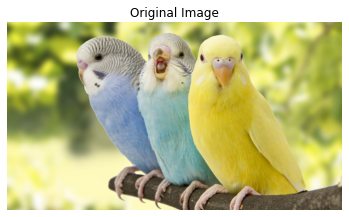

In [ ]:
from PIL import Image
import matplotlib.pyplot as plt

image = Image.open('78996-istock-682216682.jpg')
plt.figure()
plt.title('Original Image')
plt.axis('off')
plt.imshow(image)
plt.show()

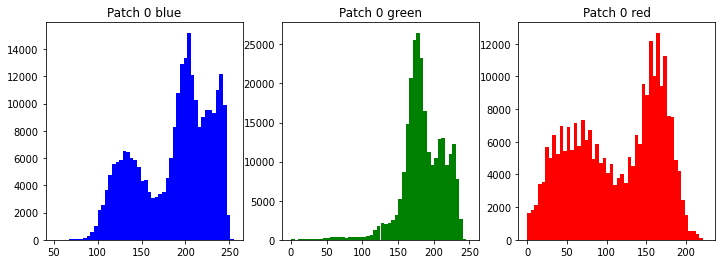

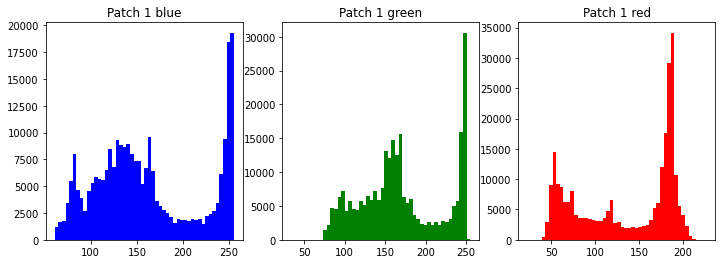

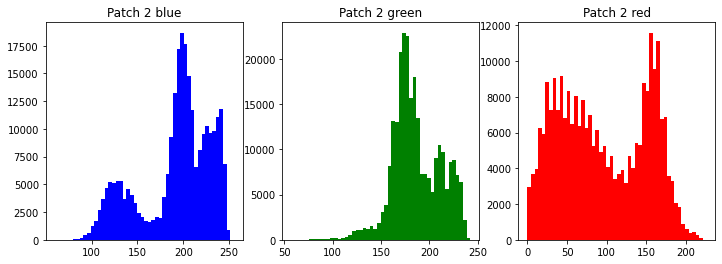

In [ ]:
import numpy as np
arr = np.array(image)
H, W, _ = arr.shape

colors = ['blue', 'green', 'red']
for i in range(3):
    fig, axs = plt.subplots(1, 3, figsize=(12, 4))
    r = np.random.randint(0, H - 512)
    c = np.random.randint(0, W - 512)
    patch = arr[r:r+512, c:c+512]

    for j in range(3):
        axs[j].set_title(f'Patch {i} {colors[j]}')
        axs[j].hist(patch[:, :, j].reshape(-1), bins=50, color=colors[j])
    plt.show()

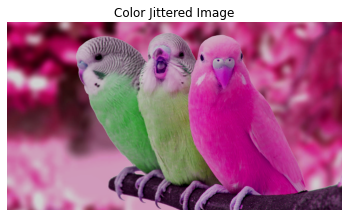

In [ ]:
from torchvision import transforms

color_jitter = transforms.ColorJitter(0.4, 0.4, 0.4, 0.4)
jitter_img = color_jitter(image)

image = Image.open('78996-istock-682216682.jpg')
plt.figure()
plt.title('Color Jittered Image')
plt.axis('off')
plt.imshow(jitter_img)
plt.show()

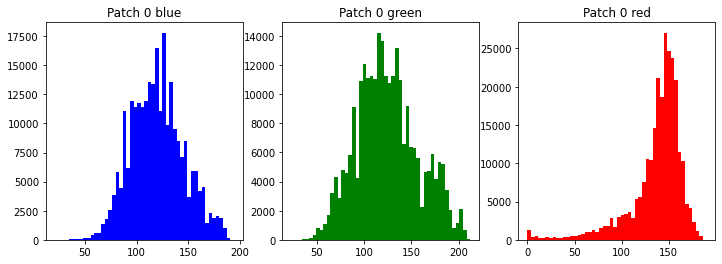

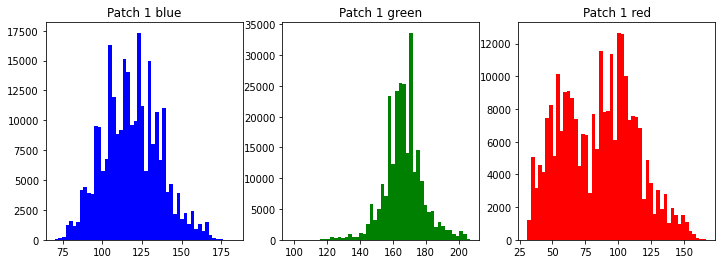

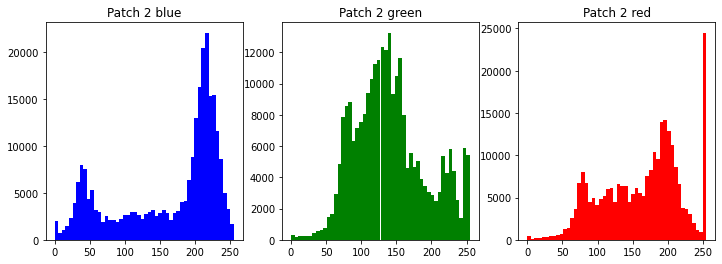

In [ ]:
arr = np.array(image)
H, W, _ = arr.shape

colors = ['blue', 'green', 'red']
for i in range(3):
    arr = np.array(color_jitter(image))

    fig, axs = plt.subplots(1, 3, figsize=(12, 4))
    r = np.random.randint(0, H - 512)
    c = np.random.randint(0, W - 512)
    patch = arr[r:r+512, c:c+512]

    for j in range(3):
        axs[j].set_title(f'Patch {i} {colors[j]}')
        axs[j].hist(patch[:, :, j].reshape(-1), bins=50, color=colors[j])
    plt.show()

In [8]:
contrast_transforms = transforms.Compose([transforms.RandomHorizontalFlip(),
                                          transforms.RandomResizedCrop(size=32),
                                          transforms.RandomApply([
                                              transforms.ColorJitter(brightness=0.5, 
                                                                     contrast=0.5, 
                                                                     saturation=0.5, 
                                                                     hue=0.1)
                                          ], p=0.8),
                                          transforms.RandomGrayscale(p=0.2),
                                          transforms.GaussianBlur(kernel_size=9),
                                          transforms.ToTensor(),
                                          transforms.Normalize((0.5,), (0.5,))
                                         ])

In [ ]:
train_data = CIFAR10(root='./', train=True, download=True, 
                       transform=ContrastiveTransformations(contrast_transforms, n_views=2))
test_data = CIFAR10(root='./', train=False, download=True, 
                        transform=transforms.Compose([transforms.ToTensor(), transforms.Normalize((0.5,), (0.5,))]))

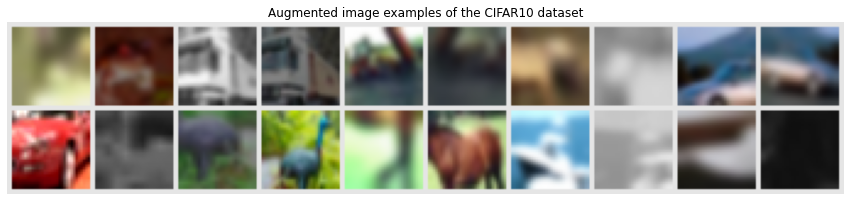

In [ ]:
NUM_IMAGES = 10
imgs = torch.stack([img for idx in range(NUM_IMAGES) for img in train_data[idx][0]], dim=0)
img_grid = torchvision.utils.make_grid(imgs, nrow=10, normalize=True, pad_value=0.9)
img_grid = img_grid.permute(1, 2, 0)

plt.figure(figsize=(15,8))
plt.title('Augmented image examples of the CIFAR10 dataset')
plt.imshow(img_grid)
plt.axis('off')
plt.show()
plt.close()

In [ ]:
model2 = SimCLR().to(device)
fit(model2)

  0%|          | 0/20 [00:00<?, ?it/s]

[ 0/20]:loss=5.8100 acc=0.0952
[ 1/20]:loss=5.3296 acc=0.1885
[ 2/20]:loss=5.0698 acc=0.2492
[ 3/20]:loss=4.8919 acc=0.2855
[ 4/20]:loss=4.7416 acc=0.3155
[ 5/20]:loss=4.6457 acc=0.3357
[ 6/20]:loss=4.5374 acc=0.3537
[ 7/20]:loss=4.4628 acc=0.3648
[ 8/20]:loss=4.4036 acc=0.3769
[ 9/20]:loss=4.3502 acc=0.3855
[10/20]:loss=4.2997 acc=0.3925
[11/20]:loss=4.2751 acc=0.3983
[12/20]:loss=4.2426 acc=0.4038
[13/20]:loss=4.1861 acc=0.4126
[14/20]:loss=4.1668 acc=0.4153
[15/20]:loss=4.1483 acc=0.4188
[16/20]:loss=4.1347 acc=0.4220
[17/20]:loss=4.1435 acc=0.4218
[18/20]:loss=4.1125 acc=0.4232
[19/20]:loss=4.1073 acc=0.4243


In [10]:
model2 = SimCLR()
model2.load_state_dict(torch.load('simclr.pkl', map_location=device))
model2.eval()
res2 = test_classification(model2)
np.mean(res2)

0.45520000000000005

In [ ]:
model2.eval()
res2 = test_classification(model2)
np.mean(res2)

0.4537999999999999

# No batch norm

In [11]:
class Net(nn.Module):
    def __init__(self, out_dim=128, hid_dim_full=128):
        super(Net, self).__init__()

        self.conv1 = nn.Conv2d(3, 16, 5, padding=2)
        self.conv2 = nn.Conv2d(16, 16, 3, padding=1, stride=2)
        self.conv3 = nn.Conv2d(16, 32, 5, padding=2)
        self.conv4 = nn.Conv2d(32, 32, 3, padding=1, stride=2)
        self.conv5 = nn.Conv2d(32, 32, 1)
        self.conv6 = nn.Conv2d(32, 4, 1)

        self.conv_to_fc = 8 * 8 * 4
        self.fc1 = nn.Linear(self.conv_to_fc, hid_dim_full)
        self.fc2 = nn.Linear(hid_dim_full, int(hid_dim_full // 2))

        self.features = nn.Linear(int(hid_dim_full // 2), out_dim)


    def forward(self, x):

        x = F.relu(self.conv1(x))
        x = F.relu(self.conv2(x))
        x = F.relu(self.conv3(x))
        x = F.relu(self.conv4(x))
        x = F.relu(self.conv5(x))
        x = F.relu(self.conv6(x))

        x = x.view(-1, self.conv_to_fc)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))

        features = self.features(x)

        return features

In [ ]:
model3 = SimCLR()
model3.load_state_dict(torch.load('simclr_bn.pkl', map_location=device))

In [21]:
model3.eval()
res3 = test_classification(model3)
np.mean(res3)
np.mean(res3)

0.4827

In [15]:
from scipy.stats import wilcoxon

In [18]:
wilcoxon(res2, res3)

WilcoxonResult(statistic=0.0, pvalue=0.005062032126267864)